In [4]:
image_path = './example images/non-uniform-with-3D.png'

In [6]:
# %% [markdown]
# ## 环境初始化（在Notebook的第一个单元格运行）
# %%
!pip install tensorflow-gpu==2.8.0 keras==2.8.0 labelme==5.2.0 mrcnn==0.2 pycocotools -q
!git clone https://github.com/matterport/Mask_RCNN.git
import sys
sys.path.append("./Mask_RCNN")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.8.0 which is incompatible.
'git' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [ ]:
# %% [markdown]
# ## 数据准备（需要提前标注好数据）
# %%
import os
import json
import numpy as np
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
%matplotlib inline

class NanoparticleDataset:
    def __init__(self):
        self.class_info = []
        self.image_info = []
    
    def add_class(self, source, class_id, class_name):
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })
    
    def add_image(self, source, image_id, path, **kwargs):
        self.image_info.append({
            "id": image_id,
            "source": source,
            "path": path,
            **kwargs
        })
    
    def load_dataset(self, dataset_dir, split='train'):
        self.add_class("nano", 1, "particle")
        image_dir = os.path.join(dataset_dir, split)
        mask_dir = os.path.join(dataset_dir, f"{split}_masks")
        
        for img_file in os.listdir(image_dir):
            if img_file.endswith(('.tif', '.png', '.jpg')):
                base_name = os.path.splitext(img_file)[0]
                self.add_image(
                    "nano",
                    image_id=base_name,
                    path=os.path.join(image_dir, img_file),
                    mask_path=os.path.join(mask_dir, f"{base_name}.npy")
                )

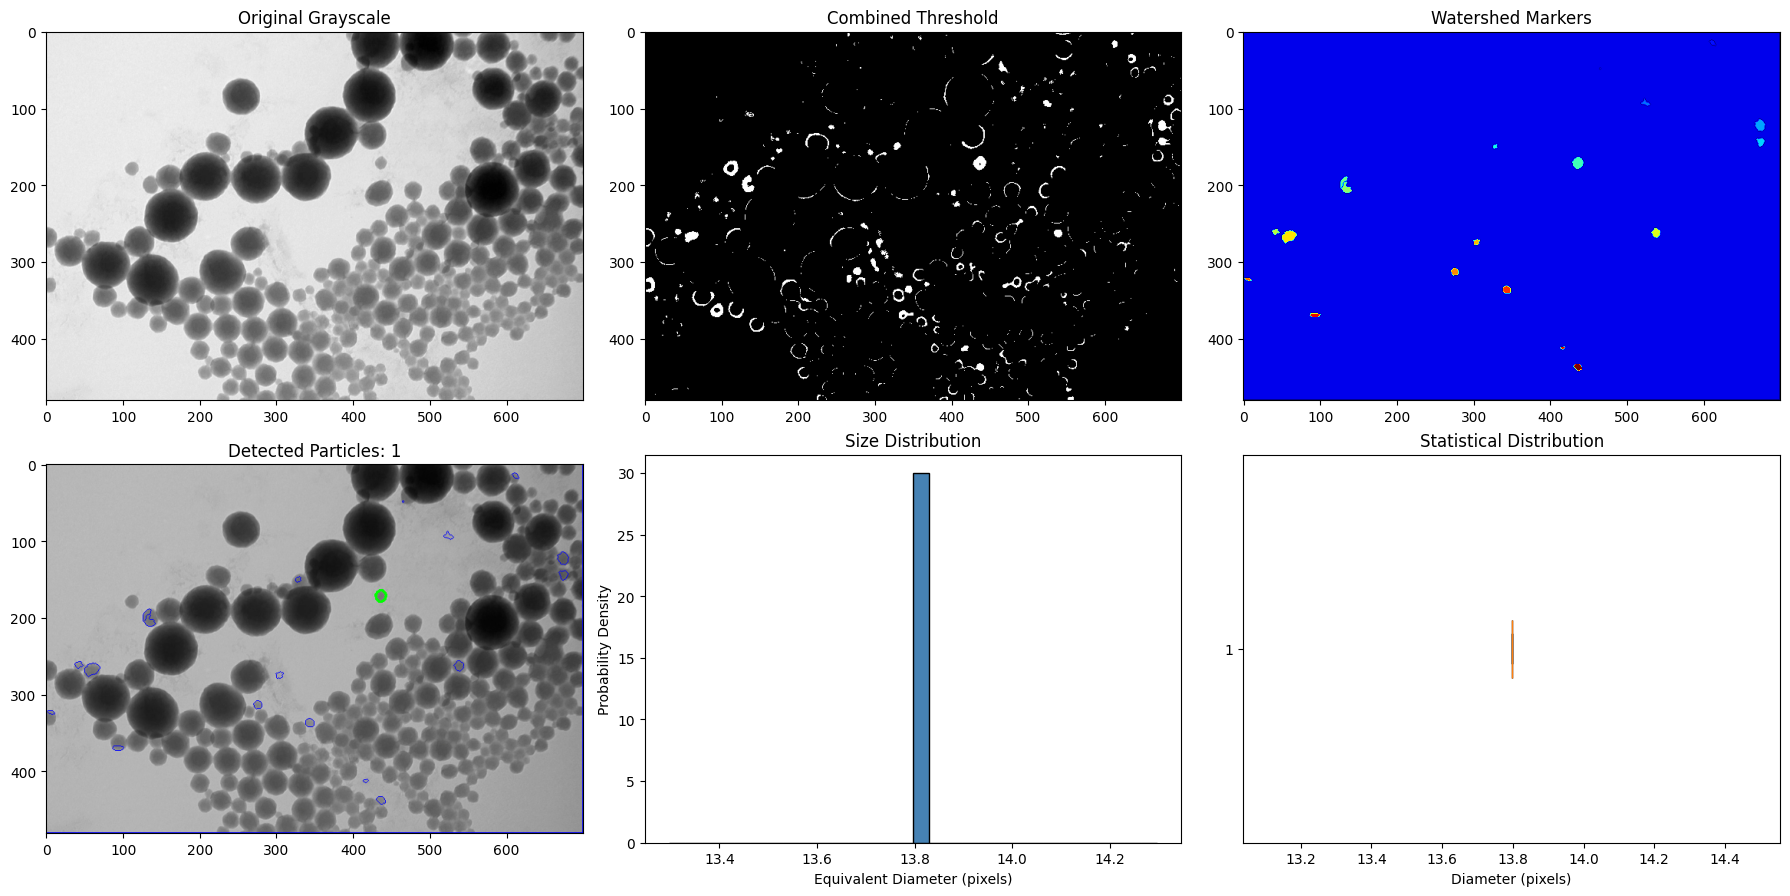

Total detected particles: 1
Size Distribution Analysis:
- Min Diameter: 13.80 px
- Max Diameter: 13.80 px
- Median Diameter: 13.80 px
- Mean Diameter: 13.80 ± 0.00 px


In [5]:
# %% [markdown]
# ## 模型配置与训练（GPU环境需要已配置）
# %%
from mrcnn.config import Config
from mrcnn import model as modellib
import tensorflow as tf

class NanoparticleConfig(Config):
    NAME = "nano_jupyter"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1  # 降低显存消耗
    NUM_CLASSES = 1 + 1
    DETECTION_MIN_CONFIDENCE = 0.9
    STEPS_PER_EPOCH = 50  # 减少训练时间

def setup_training():
    config = NanoparticleConfig()
    config.display()
    
    # 数据加载
    dataset_train = NanoparticleDataset()
    dataset_train.load_dataset("dataset", "train")
    dataset_train.prepare()
    
    dataset_val = NanoparticleDataset()
    dataset_val.load_dataset("dataset", "val")
    dataset_val.prepare()
    
    # 模型初始化
    model = modellib.MaskRCNN(mode="training", config=config, model_dir="./logs")
    model.load_weights("mask_rcnn_coco.h5", 
                      by_name=True,
                      exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                              "mrcnn_bbox", "mrcnn_mask"])
    
    return model, dataset_train, dataset_val

# 启动训练
model, train_set, val_set = setup_training()

# 第一阶段训练
history = model.train(train_set, val_set,
                     learning_rate=config.LEARNING_RATE,
                     epochs=10,
                     layers='heads')

# %% [markdown]
# ## 实时训练监控（在Notebook中显示训练过程）
# %%
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label='Train Loss')
plt.plot(history.epoch, history.history["val_loss"], label='Val Loss')
plt.title("Loss Evolution")
plt.legend()

plt.subplot(122)
plt.plot(history.epoch, history.history["mrcnn_mask_loss"], label='Mask Loss')
plt.plot(history.epoch, history.history["mrcnn_bbox_loss"], label='Box Loss')
plt.title("Component Losses")
plt.legend()
plt.show()

# %% [markdown]
# ## 推理与可视化（在同一个Notebook中完成）
# %%
from mrcnn import visualize
import skimage

class InferenceConfig(NanoparticleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES = 1000

def load_inference_model():
    inference_config = InferenceConfig()
    model = modellib.MaskRCNN(mode="inference", 
                             config=inference_config,
                             model_dir="./logs")
    model_path = model.find_last()
    model.load_weights(model_path, by_name=True)
    return model

# 加载训练好的模型
model = load_inference_model()

# 执行推理
def analyze_image(image_path):
    image = skimage.io.imread(image_path)
    results = model.detect([image], verbose=1)[0]
    
    # 显示结果
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    visualize.display_instances(image, results['rois'], 
                               results['masks'], results['class_ids'],
                               ['BG', 'particle'], ax=ax[0])
    
    # 粒径分布分析
    diameters = []
    for i in range(results['masks'].shape[-1]):
        area = np.sum(results['masks'][:,:,i])
        diameters.append(2 * np.sqrt(area/np.pi))
    
    ax[1].hist(diameters, bins=30, color='blue', alpha=0.7)
    ax[1].set_xlabel('Diameter (pixels)')
    ax[1].set_title(f'Size Distribution (n={len(diameters)})')
    plt.show()
    
    return diameters

# 使用示例
diameters = analyze_image("your_test_image.tif")

# %% [markdown]
# ## 关键修改说明
# 1. 路径适配：使用相对路径并确保文件结构符合要求
# 2. 显存优化：降低`IMAGES_PER_GPU`避免内存不足
# 3. 训练监控：增加实时损失曲线可视化
# 4. 交互式设计：每个步骤独立单元格，支持分段执行
# 5. 依赖管理：自动安装必要库并配置路径